# Libraries

In [2]:
import pandas as pd
import os
import numpy as np

#data cleansing
from sklearn.preprocessing import OneHotEncoder


#logistic regression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


#Export model
import pickle


###################################################################
# Personal library #
import sys
import os

# Path to the folder containing the pesonalized functions
folder_path = os.path.abspath(os.path.join('..', 'library'))
sys.path.insert(0, folder_path)

# Now you can import your module or functions
import la_functions as la

# Reading + Enriching the data

In [3]:
# Here I call the function data_enriching as defined in the module la_functions.py present in the folder library
df = la.data_enriching('data.csv')

# Here focus on 2023 only - to be changed as needed
#df = df.query(" year_occurred==2023 ")

/home/cris/.pyenv/versions/3.10.6/envs/safe_live/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
len(df)

210051

In [5]:
for x in df :
    print(f"'{x}',")

'division_number',
'date_reported',
'date_occurred',
'area',
'area_name',
'reporting_district',
'part',
'crime_code',
'crime_description',
'modus_operandi',
'victim_age',
'victim_sex',
'victim_descent',
'premise_code',
'premise_description',
'weapon_code',
'weapon_description',
'status',
'status_description',
'crime_code_1',
'crime_code_2',
'crime_code_3',
'crime_code_4',
'location',
'cross_street',
'latitude',
'longitude',
'counter',
'year_occurred',
'month_occurred',
'day_occurred',
'hour_occurred',
'geometry',
'index_right',
'OBJECTID',
'name',
'gravity_for_tourist',


# Getting the data

In [6]:
columns_keep = [
#'division_number',
#'date_reported',
'date_occurred',
#'area',
#'area_name',
#'reporting_district',
#'part',
#'crime_code',
#'crime_description',
#'modus_operandi',
'victim_age',
'victim_sex',
'victim_descent',
#'premise_code',
#'premise_description',
#'weapon_code',
#'weapon_description',
#'status',
#'status_description',
#'crime_code_1',
#'crime_code_2',
#'crime_code_3',
#'crime_code_4',
#'location',
#'cross_street',
'latitude',
'longitude',
'year_occurred',
'month_occurred',
'hour_occurred',
'geometry',#not for model
'index_right',#not for model
'OBJECTID',#not for model
'name',#name area
'gravity_for_tourist'# target
]

In [7]:
df = df[columns_keep]
df.head(3)

,date_occurred,victim_age,victim_sex,victim_descent,latitude,longitude,year_occurred,month_occurred,hour_occurred,geometry,index_right,OBJECTID,name,gravity_for_tourist
0,2020-01-08 22:30:00,36,F,B,34.0141,-118.2978,2020,1,22,POINT (-118.29780 34.01410),31.0,32.0,Exposition Park,1
1,2020-01-01 03:30:00,25,M,H,34.0459,-118.2545,2020,1,3,POINT (-118.25450 34.04590),23.0,24.0,Downtown,1
2,2020-02-13 12:00:00,0,X,X,34.0448,-118.2474,2020,2,12,POINT (-118.24740 34.04480),23.0,24.0,Downtown,1


# Data Cleansing

## 1. Basic Cleansing

In [8]:
#Removing illogical values and replacing erronous values

#removing negative age values
df=df[df['victim_age']>=0]

#removing null gender values
df = df[df['victim_sex'].notnull()]
df = df[df['victim_descent'].notnull()]


In [9]:
#exploring unique values for victim descent and victim sex columns
df['victim_sex'].unique(), df['victim_descent'].unique()

(array(['M', 'X', 'F', 'H', '-'], dtype=object),
 array(['W', 'X', 'H', 'O', 'B', 'F', 'A', 'K', 'C', 'J', 'Z', 'I', 'D',
        'V', 'G', 'P', 'S', 'L', 'U', '-'], dtype=object))

In [10]:
# from the above cell , '-' is present in both columns so we need to remove rows that contain it (they're not that many)
df=df[df['victim_sex'] != '-']
df=df[df['victim_descent'] != '-']

In [11]:
#checking the above code worked
df['victim_sex'].unique(), df['victim_descent'].unique()

(array(['M', 'X', 'F', 'H'], dtype=object),
 array(['W', 'X', 'H', 'O', 'B', 'F', 'A', 'K', 'C', 'J', 'Z', 'I', 'D',
        'V', 'G', 'P', 'S', 'L', 'U'], dtype=object))

In [12]:
len(df)

181259

# This one is included in the data_enriching function
# Parse datetime string to datetime object

df['date_occurred'] = pd.to_datetime(df['date_occurred'], errors='coerce')

#create new date and time columns
df['year_occurred'] = df['date_occurred'].dt.year
df['month_occurred'] = df['date_occurred'].dt.month
df['hour_occurred'] = df['date_occurred'].dt.hour
df['day_occurred'] = df['date_occurred'].dt.day

df.head(3)

In [13]:
# Create new column 'time_of_day' based on time
def categorize_time(hour):
    if 6 <= hour < 12:
        return 1#'morning'
    elif 12 <= hour < 18:
        return 2#'afternoon'
    elif 18 <= hour < 24:
        return 3#'evening'
    else:
        return 4#'night'

df['time_of_day'] = df['hour_occurred'].apply(categorize_time)

## 1.2 one hot encoding victim_sex and victim_descent

In [14]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [15]:
df = pd.get_dummies(df, columns=['victim_descent', 'victim_sex'])
df = df.replace({True: 1, False: 0})

df.head()

/tmp/ipykernel_1612/3463276855.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


,date_occurred,victim_age,latitude,longitude,year_occurred,month_occurred,hour_occurred,geometry,index_right,OBJECTID,name,gravity_for_tourist,time_of_day,victim_descent_A,victim_descent_B,victim_descent_C,victim_descent_D,victim_descent_F,victim_descent_G,victim_descent_H,victim_descent_I,victim_descent_J,victim_descent_K,victim_descent_L,victim_descent_O,victim_descent_P,victim_descent_S,victim_descent_U,victim_descent_V,victim_descent_W,victim_descent_X,victim_descent_Z,victim_sex_F,victim_sex_H,victim_sex_M,victim_sex_X
225174,2023-07-03 14:00:00,33,34.0330,-118.4324,2023,7,14,POINT (-118.43240 34.03300),77.0,78.0,Rancho Park,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
409723,2023-06-17 11:40:00,0,34.0981,-118.3092,2023,6,11,POINT (-118.30920 34.09810),25.0,26.0,East Hollywood,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
409779,2023-02-11 16:30:00,48,34.0396,-118.2726,2023,2,16,POINT (-118.27260 34.03960),23.0,24.0,Downtown,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
409947,2023-01-23 12:00:00,60,34.2138,-118.5951,2023,1,12,POINT (-118.59510 34.21380),12.0,13.0,Canoga Park,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
411222,2023-05-16 15:50:00,22,34.0539,-118.2712,2023,5,15,POINT (-118.27120 34.05390),106.0,107.0,Westlake,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# ML Competition - Final Dataset

In [41]:
###########################################################################
#Cris Libray
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

In [16]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 181259 entries, 225174 to 852949
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date_occurred        181259 non-null  datetime64[ns]
 1   victim_age           181259 non-null  int64         
 2   latitude             181259 non-null  float64       
 3   longitude            181259 non-null  float64       
 4   year_occurred        181259 non-null  int32         
 5   month_occurred       181259 non-null  int32         
 6   hour_occurred        181259 non-null  int32         
 7   geometry             181259 non-null  geometry      
 8   index_right          179493 non-null  float64       
 9   OBJECTID             179493 non-null  float64       
 10  name                 179493 non-null  object        
 11  gravity_for_tourist  181259 non-null  int64         
 12  time_of_day          181259 non-null  int64         
 13  victim

In [17]:
df=df[df['victim_age']>0]

columns_keep = [
'date_occurred',
'crime_description',
'victim_age',
'victim_sex',
'victim_descent',
'year_occurred',
'month_occurred',
'hour_occurred',
'geometry',#not for model
'index_right',#not for model
'OBJECTID',#not for model
'name',#name area
'gravity_for_tourist'# target
]

In [18]:
df['gravity_for_tourist'] = df['gravity_for_tourist'].astype(str)

In [19]:
#Create the feature set
features = [
    'victim_age',
    'month_occurred',
    'year_occured'
    'time_of_day',
    'latitude',
    'longitude',
    'victim_descent_A',
    'victim_descent_B',
    'victim_descent_C',
    'victim_descent_D',
    'victim_descent_F',
    'victim_descent_G',
    'victim_descent_H',
    'victim_descent_I',
    'victim_descent_J',
    'victim_descent_K',
    'victim_descent_L',
    'victim_descent_O',
    'victim_descent_P',
    'victim_descent_S',
    'victim_descent_U',
    'victim_descent_V',
    'victim_descent_W',
    'victim_descent_X',
    'victim_descent_Z',
    'victim_sex_F',
    'victim_sex_H',
    'victim_sex_M',
    'victim_sex_X'
    ]
X = df[features]
y = df['gravity_for_tourist']

In [20]:
X.head()

,victim_age,month_occurred,time_of_day,latitude,longitude,victim_descent_A,victim_descent_B,victim_descent_C,victim_descent_D,victim_descent_F,victim_descent_G,victim_descent_H,victim_descent_I,victim_descent_J,victim_descent_K,victim_descent_L,victim_descent_O,victim_descent_P,victim_descent_S,victim_descent_U,victim_descent_V,victim_descent_W,victim_descent_X,victim_descent_Z,victim_sex_F,victim_sex_H,victim_sex_M,victim_sex_X
225174,33,7,2,34.0330,-118.4324,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
409779,48,2,2,34.0396,-118.2726,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
409947,60,1,2,34.2138,-118.5951,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
411222,22,5,2,34.0539,-118.2712,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
411278,3,4,3,34.0504,-118.3832,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [21]:
y.head()

225174    1
409779    1
409947    2
411222    1
411278    2
Name: gravity_for_tourist, dtype: object

<Axes: title={'center': 'Boxplot of the victim_age'}, xlabel='victim_age'>

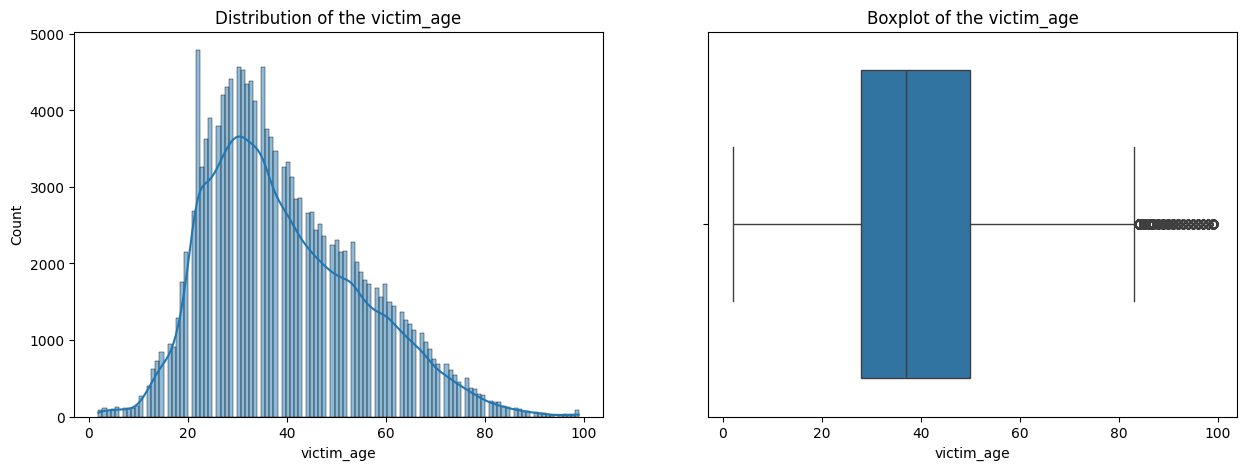

In [25]:
# It is crucial to to understand the overall distribution, the potential outliers...
# and also the Gaussianity with QQplot... before Scaling!

variable = 'victim_age'

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = df, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = df, x = f"{variable}", ax=ax[1])


## Scaling

In [51]:
#scaler = RobustScaler()
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features)

In [52]:
df_scaled.head()

,victim_age,month_occurred,time_of_day,latitude,longitude,victim_descent_A,victim_descent_B,victim_descent_C,victim_descent_D,victim_descent_F,victim_descent_G,victim_descent_H,victim_descent_I,victim_descent_J,victim_descent_K,victim_descent_L,victim_descent_O,victim_descent_P,victim_descent_S,victim_descent_U,victim_descent_V,victim_descent_W,victim_descent_X,victim_descent_Z,victim_sex_F,victim_sex_H,victim_sex_M,victim_sex_X
0,-0.418598,0.331455,-0.398255,-0.222580,-0.147714,-0.176482,-0.467078,-0.081534,-0.01227,-0.079642,-0.011442,-0.829213,-0.037276,-0.04617,-0.087921,-0.011152,-0.313379,-0.019655,-0.00809,-0.015137,-0.041446,1.773821,-0.160092,-0.028036,-0.970994,-0.010855,1.001769,-0.125389
1,0.532737,-1.245843,-0.398255,-0.187130,0.150957,-0.176482,-0.467078,-0.081534,-0.01227,-0.079642,-0.011442,1.205963,-0.037276,-0.04617,-0.087921,-0.011152,-0.313379,-0.019655,-0.00809,-0.015137,-0.041446,-0.563755,-0.160092,-0.028036,-0.970994,-0.010855,1.001769,-0.125389
2,1.293805,-1.561303,-0.398255,0.748537,-0.451805,-0.176482,-0.467078,-0.081534,-0.01227,-0.079642,-0.011442,1.205963,-0.037276,-0.04617,-0.087921,-0.011152,-0.313379,-0.019655,-0.00809,-0.015137,-0.041446,-0.563755,-0.160092,-0.028036,1.029872,-0.010855,-0.998234,-0.125389
3,-1.116244,-0.299464,-0.398255,-0.110322,0.153574,-0.176482,-0.467078,-0.081534,-0.01227,-0.079642,-0.011442,1.205963,-0.037276,-0.04617,-0.087921,-0.011152,-0.313379,-0.019655,-0.00809,-0.015137,-0.041446,-0.563755,-0.160092,-0.028036,-0.970994,-0.010855,1.001769,-0.125389
4,-2.321269,-0.614924,0.611848,-0.129121,-0.055757,-0.176482,-0.467078,-0.081534,-0.01227,-0.079642,-0.011442,-0.829213,-0.037276,-0.04617,-0.087921,-0.011152,3.191020,-0.019655,-0.00809,-0.015137,-0.041446,-0.563755,-0.160092,-0.028036,-0.970994,-0.010855,1.001769,-0.125389


<Axes: title={'center': 'Boxplot of the victim_age'}, xlabel='victim_age'>

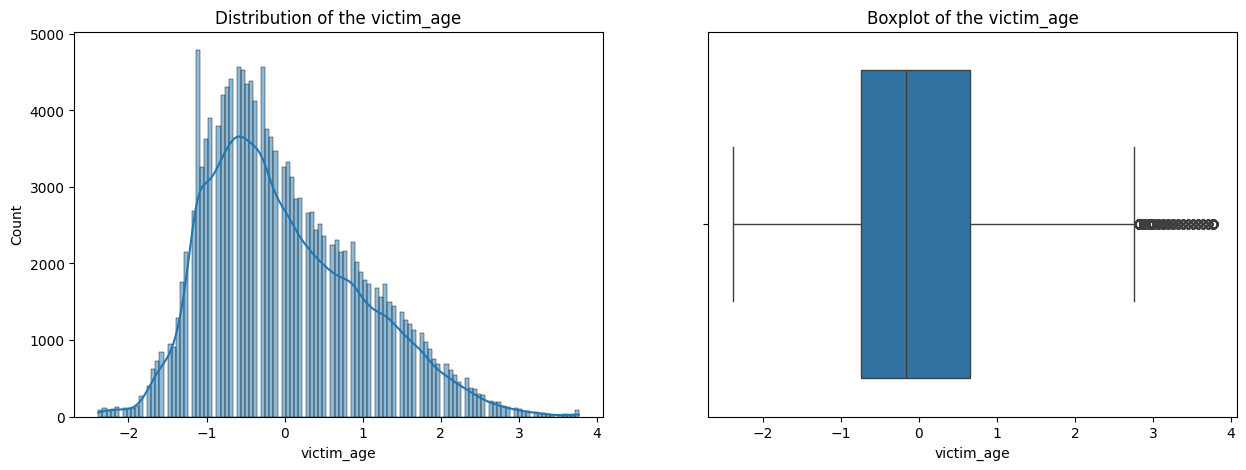

In [53]:
variable = 'victim_age'

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = df_scaled, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = df_scaled, x = f"{variable}", ax=ax[1])

## Random forest with Scalling

In [54]:
model = RandomForestClassifier (max_depth=30,min_samples_leaf=20)

In [55]:
#train and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.3,
                                                    random_state=0)

In [56]:
#Fit the model
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=20)

In [57]:
# Predict
y_pred = model.predict(X_test)

In [1]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

NameError: name 'y_test' is not defined

In [59]:
#Optimization

param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [10, 20, 30, 40, 50]
}

model = RandomForestClassifier(max_depth=30, min_samples_leaf=20)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


print("Best hyperparameters :", grid_search.best_params_)


best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

Best hyperparameters : {'max_depth': 30, 'min_samples_leaf': 10}


In [60]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7138338023867181


## Learning curves 

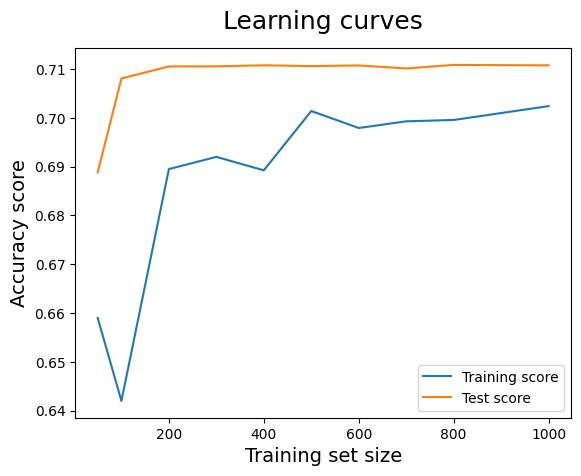

In [64]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = RandomForestClassifier(max_depth=30, min_samples_leaf=10),
                                                              X = X_scaled,
                                                              y = y,
                                                              train_sizes = [50,100,200,300,400,500,600,700,800,1000],
                                                              cv = 20)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend()

# Export model

In [ ]:
# Export model as pickle file
with open("ml_model.pkl", "wb") as file:
    pickle.dump(log_model, file)

# Load Pipeline from pickle file
my_model = pickle.load(open("ml_model.pkl","rb"))

my_model.score(X_test, y_test)

# Import model

In [ ]:
# Load pipeline from pickle file
my_model = pickle.load(open("ml_model.pkl", "rb"))

my_model